In [1]:
#Headers
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline

#Installing Libraries
!pip install haversine
!pip install vincenty

from vincenty import vincenty
from haversine import haversine, Unit

  Created wheel for vincenty: filename=vincenty-0.1.4-py3-none-any.whl size=3078 sha256=627ca050e2a89d4f984395c9108931621b75dbbe6ce7320dd9056b9935af73ae
  Stored in directory: /root/.cache/pip/wheels/2f/4d/df/6e2ce31c63c93508b38ed9098c1483e7616b55a6ddabcd2f5b
Successfully built vincenty


In [2]:
#Pull out the location data
def getLocationFrame() : 

    dataframe = pd.read_csv('../input/dbscan/Business Dataset (Texas).csv', usecols = ["latitude", "longitude", "city"])
        
    return dataframe

df = getLocationFrame()

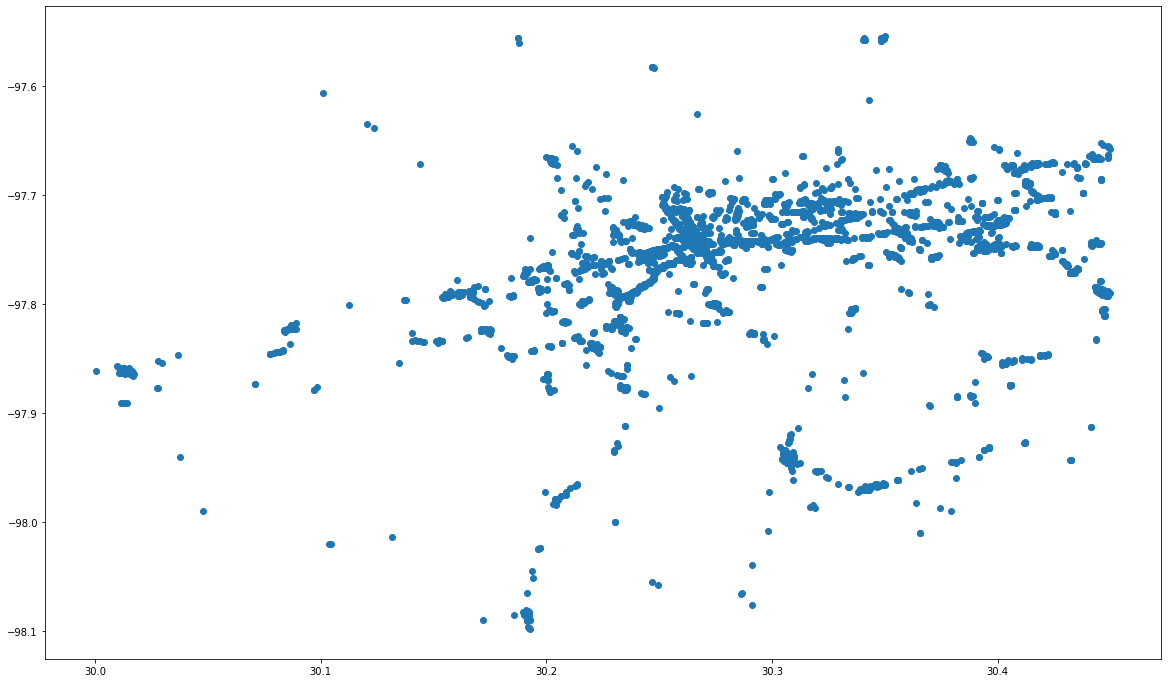

In [3]:
#Virtualize the points
plt.figure(figsize=(20,12))
plt.scatter(df["latitude"], df["longitude"])

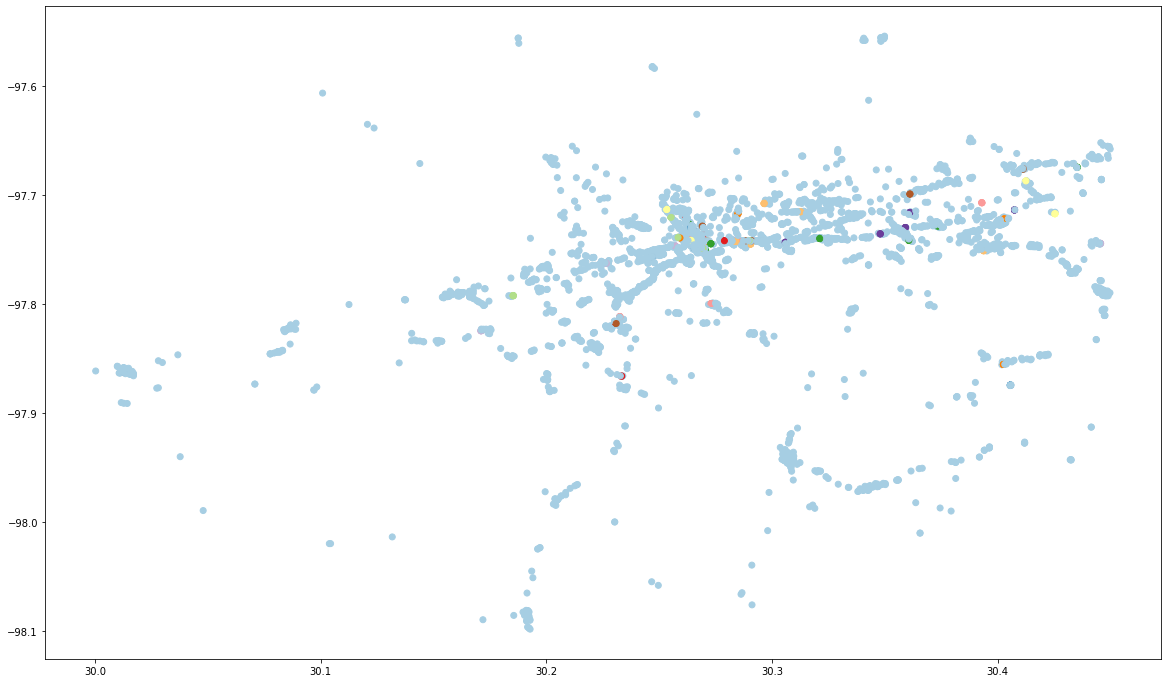

In [4]:
from sklearn.cluster import DBSCAN

#Input has to be in kms
radius = 0.5 * 1.6 
crowd_factor = 4

db = DBSCAN(eps=radius/6371., min_samples=crowd_factor, algorithm='ball_tree', metric='haversine')
y_pred = db.fit_predict(df[["latitude", "longitude"]])

plt.figure(figsize=(20,12))
plt.scatter(df["latitude"], df["longitude"],c=y_pred, cmap='Paired')

In [5]:
#Contradiction - DBSCAN Sensitivity to hyperparameters
from collections import Counter

indices = [i for i, x in enumerate(y_pred) if x == -1]
error = 0

for src in indices : 
    
    count = 1
    srcpoint = [df["latitude"][src], df["longitude"][src]]
    
    for dst, row in df.iterrows() : 
        
        dstpoint = [row["latitude"], row["longitude"]]
        
        if src != dst and haversine(srcpoint, dstpoint) <= radius : 
            
            count += 1 #Neighbouring restaurant
            
        if count > crowd_factor : 
            
            error += 1 #The restaurant should be classified as crowded!
            break

            
print("Number of outliers: ", len(indices))
print("Number of restaurant contradicting: ", error)

Number of outliers:  3259
Number of restaurant contradicting:  3058


In [6]:
#Reference Sites

#DBSCAN Basics
#https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

#Distance Matrix calculation
#https://docs.scipy.org/doc/scipy/reference/spatial.distance.html
#https://pypi.org/project/haversine/
#https://pypi.org/project/vincenty/

#Others
#https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
#https://stackoverflow.com/questions/34579213/dbscan-for-clustering-of-geographic-location-data


#The Earth Distance
#https://gis.stackexchange.com/questions/58653/what-is-approximate-error-of-pythagorean-theorem-vs-haversine-formula-in-measur
#https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_elevation
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html
#https://www.timvink.nl/closest-coordinates/

In [7]:
#Let's go Brute Force - Time Complexity
radius = 0.5 * 1.6 #in Kms
crowd_factor = 5

outlier = 0
outlier_index = []

for index, row in df.iterrows() : 
    
    srcpoint = [row["latitude"], row["longitude"]]
    count = 0
    brute_pairs = []
    
    for index_check, row_check in df.iterrows() :
        
        dstpoint = [row_check["latitude"], row_check["longitude"]]
        
        if haversine(srcpoint, dstpoint) <= radius :
            brute_pairs.append(index_check)
            count += 1
            
        if count >= crowd_factor : 
            
            break 
            
    if count < crowd_factor : 
        #print(brute_pairs)
        outlier += 1
        outlier_index.append(index)
    
print("Number of Outliers : ", outlier)
print("The Outliers are : ", outlier_index)    

Number of Outliers :  201
The Outliers are :  [15, 28, 32, 36, 41, 116, 133, 150, 152, 174, 179, 201, 239, 240, 244, 276, 282, 329, 336, 353, 380, 389, 391, 413, 430, 442, 446, 448, 470, 472, 478, 493, 498, 592, 593, 649, 655, 662, 683, 693, 698, 699, 700, 703, 709, 720, 727, 740, 796, 825, 836, 842, 856, 858, 866, 871, 882, 883, 956, 963, 964, 968, 998, 1020, 1068, 1084, 1096, 1097, 1118, 1127, 1134, 1141, 1164, 1209, 1256, 1277, 1281, 1303, 1314, 1323, 1330, 1362, 1430, 1450, 1464, 1466, 1474, 1561, 1666, 1678, 1686, 1689, 1701, 1702, 1716, 1725, 1726, 1732, 1735, 1757, 1768, 1863, 1867, 1931, 1936, 1960, 1971, 1980, 2020, 2158, 2170, 2196, 2214, 2215, 2240, 2278, 2315, 2328, 2377, 2387, 2396, 2398, 2402, 2403, 2423, 2425, 2451, 2464, 2481, 2484, 2501, 2510, 2539, 2543, 2554, 2569, 2605, 2607, 2613, 2617, 2623, 2630, 2631, 2652, 2663, 2665, 2673, 2675, 2677, 2686, 2713, 2714, 2720, 2723, 2725, 2730, 2756, 2779, 2796, 2807, 2825, 2827, 2897, 2920, 2933, 2972, 2974, 2980, 2982, 2986, 2

In [8]:
#Let's go KD-Tree - Optimal
radius = 0.5 * 1.6 #in Kms
crowd_factor = 5

outlier = 0
outlier_index = []

from scipy import spatial
import math

def cartesian(latitude, longitude, elevation = 520):
    
    # Convert to radians
    latitude = latitude * (math.pi / 180)
    longitude = longitude * (math.pi / 180)
    
    R = (6378137.0 + elevation) / 1000  # relative to centre of the earth (520m for Texas)
    X = R * math.cos(latitude) * math.cos(longitude)
    Y = R * math.cos(latitude) * math.sin(longitude)
    Z = R * math.sin(latitude)
    return (X, Y, Z)

places = []

for index, row in df.iterrows():
    coordinates = [row['latitude'], row['longitude']]
    cartesian_coord = cartesian(*coordinates)
    places.append(cartesian_coord)

tree = spatial.KDTree(places)

neighbour_count = tree.query_ball_tree(tree, r=radius, p=2) #p = 2 for euclidean distance

for i in range(0, len(neighbour_count)) : 
    
    if len(neighbour_count[i]) < crowd_factor :
        #print(neighbour_count[i])
        outlier += 1
        outlier_index.append(i)
        
print("Number of Outliers : ", outlier)
print("The Outliers are : ", outlier_index)

Number of Outliers :  201
The Outliers are :  [15, 28, 32, 36, 41, 116, 133, 150, 152, 174, 179, 201, 239, 240, 244, 276, 282, 329, 336, 353, 380, 389, 391, 413, 430, 442, 446, 448, 470, 472, 478, 493, 498, 592, 593, 649, 655, 662, 683, 693, 698, 699, 700, 703, 709, 720, 727, 740, 796, 825, 836, 842, 856, 858, 866, 871, 882, 883, 956, 963, 964, 968, 998, 1020, 1068, 1084, 1096, 1097, 1118, 1127, 1134, 1141, 1164, 1209, 1256, 1277, 1281, 1303, 1314, 1323, 1330, 1362, 1430, 1450, 1464, 1466, 1474, 1561, 1666, 1678, 1686, 1689, 1701, 1702, 1716, 1725, 1726, 1732, 1735, 1757, 1768, 1863, 1867, 1931, 1936, 1960, 1971, 1980, 2020, 2158, 2170, 2196, 2214, 2215, 2240, 2278, 2315, 2328, 2377, 2387, 2396, 2398, 2402, 2403, 2423, 2425, 2451, 2464, 2481, 2484, 2501, 2510, 2539, 2543, 2554, 2569, 2605, 2607, 2613, 2617, 2623, 2630, 2631, 2652, 2663, 2665, 2673, 2675, 2677, 2686, 2713, 2714, 2720, 2723, 2725, 2730, 2756, 2779, 2796, 2807, 2825, 2827, 2897, 2920, 2933, 2972, 2974, 2980, 2982, 2986, 2

Number of Crowded :  3429
Number of not Crowded :  201


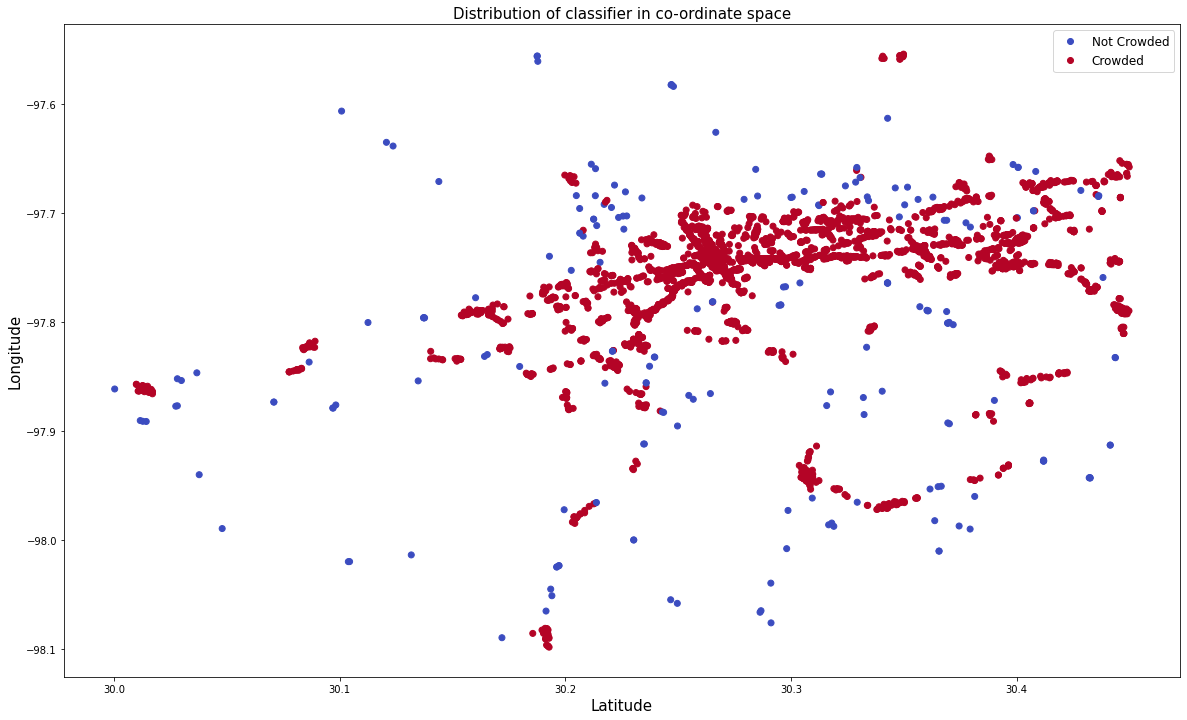

In [9]:
#Visualization Scatter Plot
crowded_label = [ ]

for i in range(len(df)) : 
    
    if i in outlier_index :
        
        crowded_label.append(0)
        
    else : 
        
        crowded_label.append(1)

plt.figure(figsize=(20,12))
scatter = plt.scatter(df["latitude"], df["longitude"],c=crowded_label, cmap="coolwarm")
plt.title("Distribution of classifier in co-ordinate space", size = 15)
plt.xlabel("Latitude", size = 15)
plt.ylabel("Longitude", size = 15)
plt.legend(handles=scatter.legend_elements()[0], labels=["Not Crowded", "Crowded"], prop={'size': 12})


print("Number of Crowded : ", len(df) - outlier)
print("Number of not Crowded : ", outlier)

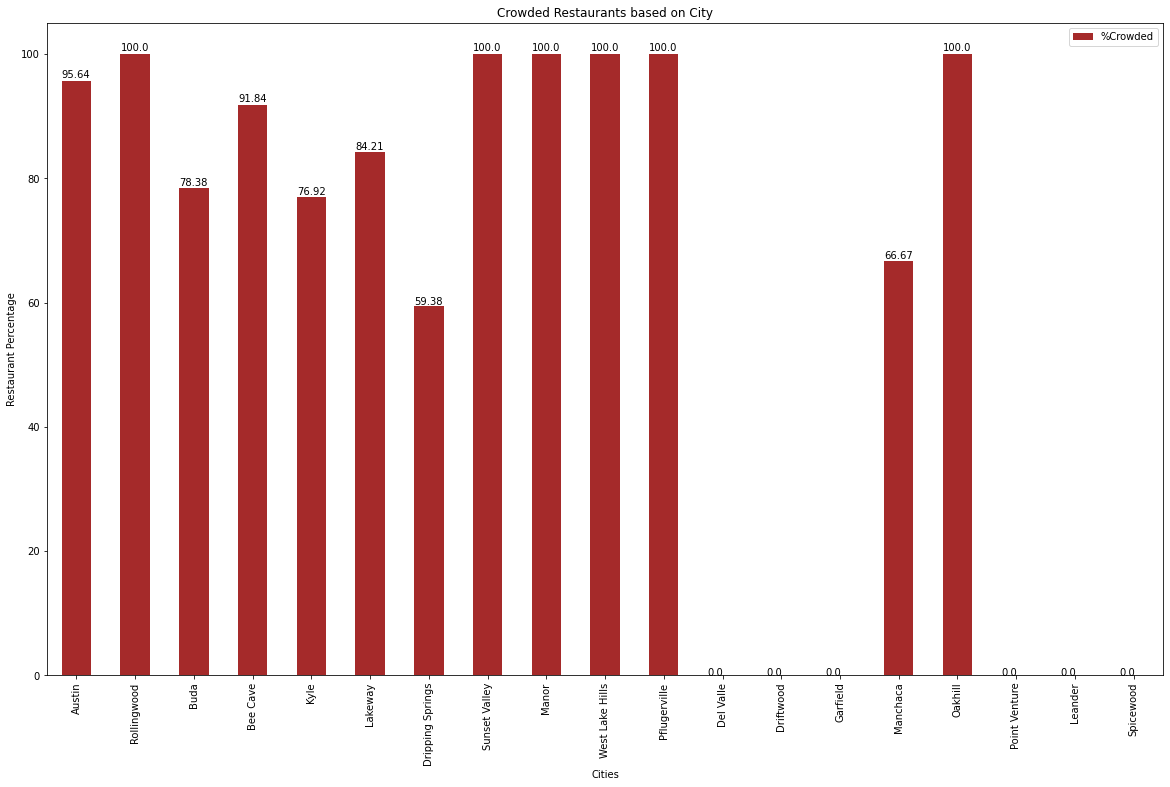

In [10]:
#Visualization Bar Plot
cities = {}

for i, row in df.iterrows() : 
    
    cities[df["city"][i]] = cities.get(df["city"][i], 0) + 1

outlier_cities = {}
crowded_cities = dict(cities)

for i in outlier_index : 
    
    outlier_cities[df["city"][i]] = outlier_cities.get(df["city"][i], 0) + 1
    crowded_cities[df["city"][i]] = crowded_cities.get(df["city"][i], 0) - 1
    
for key in cities.keys() : 
    
    crowded_cities[key] /= cities[key]
    crowded_cities[key] = round( crowded_cities[key] * 100, 2)
    
    
cities_series = pd.Series(cities.values(), index=cities.keys())
crowded_series = pd.Series(crowded_cities.values(), index=crowded_cities.keys())

plotdf = pd.DataFrame({"%Crowded":crowded_series})
ax = plotdf.plot.bar(color=["brown"], rot=90, title="Crowded Restaurants based on City", figsize=(20, 12))
ax.set_xlabel("Cities")
ax.set_ylabel("Restaurant Percentage")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.000, p.get_height() * 1.005))
plt.show()